In [1]:
import os
import tensorflow
from models.VAE import VariationalAutoencoder
from utils.loaders import load_mnist
tensorflow.compat.v1.disable_eager_execution()

In [2]:
# 실행 매개변수
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [4]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
vae.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

VAE에서는 잠재 공간의 차원 사이에서는 어떠한 상관관계가 없다고 가정한다. (두 변수가 독립이면 correlation coefficient = 0)
따라서 covariance matrix -> diagonal matrix 가 된다. 이는 인코더가 각 입력을 평균 벡터와 분산 벡터에만 매핑할 필요가 있다는 것을 뜻한다. 따라서 차원간의 공분산에 대해 신경 쓸 필요가 없다.
neural network unit의 일반적인 출력은 (-inf, inf)지만 분산은 항상 양수이므로 분산에 로그를 취한 값에 매핑한다.

요약하면, 인코더는 입력 이미지를 받아 잠재 공간의 다변수 정규 분포를 정의하는 2개의 벡터 mu, log_var로 인코딩한다.
mu : 이 분포의 평균 벡터 ,  log_var : 차원별 분산의 로그값

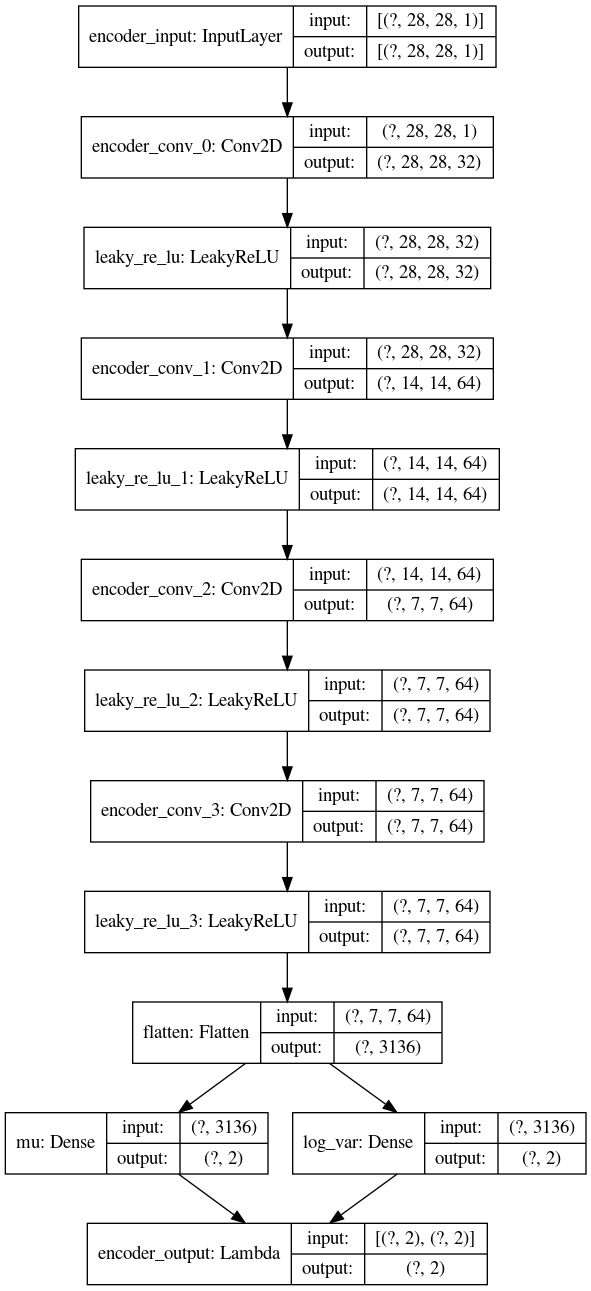

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(vae.encoder, to_file='vae_encoder.png', show_shapes = True, show_layer_names = True)

In [7]:
vae.decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

In [8]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [9]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [10]:
BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [11]:
vae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Train on 60000 samples
Epoch 1/200
60000/60000 [==============================] - ETA: 0s - loss: 58.3910 - vae_r_loss: 55.1421 - vae_kl_loss: 3.2488
Epoch 00001: saving model to run/vae/0002_digits/weights/weights-001-58.39.h5

Epoch 00001: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 42s 693us/sample - loss: 58.3910 - vae_r_loss: 55.1421 - vae_kl_loss: 3.2488 - lr: 5.0000e-04
Epoch 2/200
59936/60000 [============================>.] - ETA: 0s - loss: 51.6667 - vae_r_loss: 47.7063 - vae_kl_loss: 3.9603
Epoch 00002: saving model to run/vae/0002_digits/weights/weights-002-51.66.h5

Epoch 00002: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 41s 679us/sample - loss: 51.6642 - vae_r_loss: 47.7034 - vae_kl_loss: 3.9608 - lr: 5.0000e-04
Epoch 3/200
59968/60000 [============================>.] - ETA: 0s - loss: 50.0914 - vae_r_loss: 45.8007 - vae_kl_loss: 4.2907
Epoch 00003: saving 

60000/60000 [==============================] - 39s 648us/sample - loss: 45.9033 - vae_r_loss: 40.8468 - vae_kl_loss: 5.0565 - lr: 5.0000e-04
Epoch 21/200
59936/60000 [============================>.] - ETA: 0s - loss: 45.8325 - vae_r_loss: 40.7723 - vae_kl_loss: 5.0602
Epoch 00021: saving model to run/vae/0002_digits/weights/weights-021-45.83.h5

Epoch 00021: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 649us/sample - loss: 45.8333 - vae_r_loss: 40.7729 - vae_kl_loss: 5.0604 - lr: 5.0000e-04
Epoch 22/200
60000/60000 [==============================] - ETA: 0s - loss: 45.7623 - vae_r_loss: 40.6773 - vae_kl_loss: 5.0850
Epoch 00022: saving model to run/vae/0002_digits/weights/weights-022-45.76.h5

Epoch 00022: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 649us/sample - loss: 45.7623 - vae_r_loss: 40.6773 - vae_kl_loss: 5.0850 - lr: 5.0000e-04
Epoch 23/200
59968/60000 [=

60000/60000 [==============================] - 39s 649us/sample - loss: 44.9411 - vae_r_loss: 39.7425 - vae_kl_loss: 5.1986 - lr: 5.0000e-04
Epoch 41/200
59968/60000 [============================>.] - ETA: 0s - loss: 44.8943 - vae_r_loss: 39.6759 - vae_kl_loss: 5.2184
Epoch 00041: saving model to run/vae/0002_digits/weights/weights-041-44.89.h5

Epoch 00041: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 649us/sample - loss: 44.8944 - vae_r_loss: 39.6760 - vae_kl_loss: 5.2185 - lr: 5.0000e-04
Epoch 42/200
59936/60000 [============================>.] - ETA: 0s - loss: 44.8617 - vae_r_loss: 39.6432 - vae_kl_loss: 5.2185
Epoch 00042: saving model to run/vae/0002_digits/weights/weights-042-44.86.h5

Epoch 00042: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 648us/sample - loss: 44.8646 - vae_r_loss: 39.6460 - vae_kl_loss: 5.2186 - lr: 5.0000e-04
Epoch 43/200
60000/60000 [=


Epoch 00060: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 34s 563us/sample - loss: 44.4097 - vae_r_loss: 39.1269 - vae_kl_loss: 5.2828 - lr: 5.0000e-04
Epoch 61/200
59968/60000 [============================>.] - ETA: 0s - loss: 44.3958 - vae_r_loss: 39.1013 - vae_kl_loss: 5.2945
Epoch 00061: saving model to run/vae/0002_digits/weights/weights-061-44.40.h5

Epoch 00061: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 34s 562us/sample - loss: 44.3975 - vae_r_loss: 39.1028 - vae_kl_loss: 5.2946 - lr: 5.0000e-04
Epoch 62/200
59936/60000 [============================>.] - ETA: 0s - loss: 44.3704 - vae_r_loss: 39.0812 - vae_kl_loss: 5.2892
Epoch 00062: saving model to run/vae/0002_digits/weights/weights-062-44.37.h5

Epoch 00062: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 34s 563us/sample - loss: 44.3672 - vae_r_loss: 39.07

60000/60000 [==============================] - ETA: 0s - loss: 44.1033 - vae_r_loss: 38.7669 - vae_kl_loss: 5.3365
Epoch 00080: saving model to run/vae/0002_digits/weights/weights-080-44.10.h5

Epoch 00080: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 649us/sample - loss: 44.1033 - vae_r_loss: 38.7669 - vae_kl_loss: 5.3365 - lr: 5.0000e-04
Epoch 81/200
59936/60000 [============================>.] - ETA: 0s - loss: 44.0603 - vae_r_loss: 38.7218 - vae_kl_loss: 5.3385
Epoch 00081: saving model to run/vae/0002_digits/weights/weights-081-44.06.h5

Epoch 00081: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 649us/sample - loss: 44.0594 - vae_r_loss: 38.7208 - vae_kl_loss: 5.3386 - lr: 5.0000e-04
Epoch 82/200
59936/60000 [============================>.] - ETA: 0s - loss: 44.0395 - vae_r_loss: 38.6998 - vae_kl_loss: 5.3398
Epoch 00082: saving model to run/vae/0002_digits/weig

Epoch 100/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.8126 - vae_r_loss: 38.4236 - vae_kl_loss: 5.3891
Epoch 00100: saving model to run/vae/0002_digits/weights/weights-100-43.82.h5

Epoch 00100: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 653us/sample - loss: 43.8158 - vae_r_loss: 38.4269 - vae_kl_loss: 5.3890 - lr: 5.0000e-04
Epoch 101/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.8079 - vae_r_loss: 38.4276 - vae_kl_loss: 5.3802
Epoch 00101: saving model to run/vae/0002_digits/weights/weights-101-43.80.h5

Epoch 00101: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 651us/sample - loss: 43.8046 - vae_r_loss: 38.4244 - vae_kl_loss: 5.3802 - lr: 5.0000e-04
Epoch 102/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.8059 - vae_r_loss: 38.4277 - vae_kl_loss: 5.3783
Epoch 00102: saving model to run/vae/

60000/60000 [==============================] - 39s 649us/sample - loss: 43.6559 - vae_r_loss: 38.2428 - vae_kl_loss: 5.4131 - lr: 5.0000e-04
Epoch 120/200
60000/60000 [==============================] - ETA: 0s - loss: 43.6162 - vae_r_loss: 38.1994 - vae_kl_loss: 5.4168
Epoch 00120: saving model to run/vae/0002_digits/weights/weights-120-43.62.h5

Epoch 00120: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 648us/sample - loss: 43.6162 - vae_r_loss: 38.1994 - vae_kl_loss: 5.4168 - lr: 5.0000e-04
Epoch 121/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.6419 - vae_r_loss: 38.2133 - vae_kl_loss: 5.4286
Epoch 00121: saving model to run/vae/0002_digits/weights/weights-121-43.64.h5

Epoch 00121: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 648us/sample - loss: 43.6403 - vae_r_loss: 38.2117 - vae_kl_loss: 5.4287 - lr: 5.0000e-04
Epoch 122/200
60000/60000

59968/60000 [============================>.] - ETA: 0s - loss: 43.5314 - vae_r_loss: 38.0782 - vae_kl_loss: 5.4532
Epoch 00139: saving model to run/vae/0002_digits/weights/weights-139-43.53.h5

Epoch 00139: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 653us/sample - loss: 43.5318 - vae_r_loss: 38.0786 - vae_kl_loss: 5.4532 - lr: 5.0000e-04
Epoch 140/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.4554 - vae_r_loss: 38.0106 - vae_kl_loss: 5.4448
Epoch 00140: saving model to run/vae/0002_digits/weights/weights-140-43.46.h5

Epoch 00140: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 656us/sample - loss: 43.4563 - vae_r_loss: 38.0115 - vae_kl_loss: 5.4448 - lr: 5.0000e-04
Epoch 141/200
60000/60000 [==============================] - ETA: 0s - loss: 43.4669 - vae_r_loss: 38.0092 - vae_kl_loss: 5.4578
Epoch 00141: saving model to run/vae/0002_digits/we

Epoch 159/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.4077 - vae_r_loss: 37.9446 - vae_kl_loss: 5.4631
Epoch 00159: saving model to run/vae/0002_digits/weights/weights-159-43.41.h5

Epoch 00159: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 649us/sample - loss: 43.4068 - vae_r_loss: 37.9436 - vae_kl_loss: 5.4632 - lr: 5.0000e-04
Epoch 160/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.3552 - vae_r_loss: 37.8901 - vae_kl_loss: 5.4651
Epoch 00160: saving model to run/vae/0002_digits/weights/weights-160-43.36.h5

Epoch 00160: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 645us/sample - loss: 43.3570 - vae_r_loss: 37.8921 - vae_kl_loss: 5.4649 - lr: 5.0000e-04
Epoch 161/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.3205 - vae_r_loss: 37.8469 - vae_kl_loss: 5.4736
Epoch 00161: saving model to run/vae/

60000/60000 [==============================] - 39s 649us/sample - loss: 43.2270 - vae_r_loss: 37.7387 - vae_kl_loss: 5.4883 - lr: 5.0000e-04
Epoch 179/200
60000/60000 [==============================] - ETA: 0s - loss: 43.2203 - vae_r_loss: 37.7236 - vae_kl_loss: 5.4967
Epoch 00179: saving model to run/vae/0002_digits/weights/weights-179-43.22.h5

Epoch 00179: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 649us/sample - loss: 43.2203 - vae_r_loss: 37.7236 - vae_kl_loss: 5.4967 - lr: 5.0000e-04
Epoch 180/200
60000/60000 [==============================] - ETA: 0s - loss: 43.2529 - vae_r_loss: 37.7494 - vae_kl_loss: 5.5035
Epoch 00180: saving model to run/vae/0002_digits/weights/weights-180-43.25.h5

Epoch 00180: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 650us/sample - loss: 43.2529 - vae_r_loss: 37.7494 - vae_kl_loss: 5.5035 - lr: 5.0000e-04
Epoch 181/200
59936/60000

59968/60000 [============================>.] - ETA: 0s - loss: 43.1818 - vae_r_loss: 37.6735 - vae_kl_loss: 5.5083
Epoch 00198: saving model to run/vae/0002_digits/weights/weights-198-43.18.h5

Epoch 00198: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 647us/sample - loss: 43.1828 - vae_r_loss: 37.6746 - vae_kl_loss: 5.5082 - lr: 5.0000e-04
Epoch 199/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.1847 - vae_r_loss: 37.6656 - vae_kl_loss: 5.5191
Epoch 00199: saving model to run/vae/0002_digits/weights/weights-199-43.19.h5

Epoch 00199: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 39s 650us/sample - loss: 43.1873 - vae_r_loss: 37.6682 - vae_kl_loss: 5.5191 - lr: 5.0000e-04
Epoch 200/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.1390 - vae_r_loss: 37.6257 - vae_kl_loss: 5.5133
Epoch 00200: saving model to run/vae/0002_digits/we